In [30]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing, model_selection, metrics, linear_model
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# 1.  Reading the dataset

In [31]:
data = pd.read_csv("/dataset/train.csv", delimiter = ',', usecols = range(1,9))
target = pd.read_csv("/datasettrain.csv", delimiter = ',', usecols = [0]) 

In [32]:
#display the dataset
data.head(8)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY
0,39353,85475,117961,118300,123472,117905,117906,290919
1,17183,1540,117961,118343,123125,118536,118536,308574
2,36724,14457,118219,118220,117884,117879,267952,19721
3,36135,5396,117961,118343,119993,118321,240983,290919
4,42680,5905,117929,117930,119569,119323,123932,19793
5,45333,14561,117951,117952,118008,118568,118568,19721
6,25993,17227,117961,118343,123476,118980,301534,118295
7,19666,4209,117961,117969,118910,126820,269034,118638


In [33]:
data.shape

(32769, 8)

# 2. Describing the Dataset

In [34]:
data.describe()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893
std,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413
min,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000
25%,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000
50%,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000
75%,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000
max,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000


# 3. Class Distribution

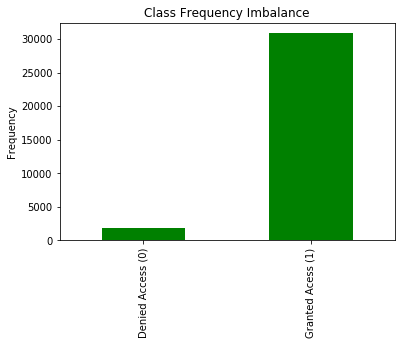

In [35]:
count_class = pd.value_counts(target.values.ravel(), sort= True).sort_index()
count_class.plot(kind = "bar", color = "green")
plt.ylabel("Frequency")
plt.xticks(np.arange(2), ('Denied Access (0)', 'Granted Acess (1)'))
plt.title("Class Frequency Imbalance")
plt.show()

# 4.  Correlation Plot

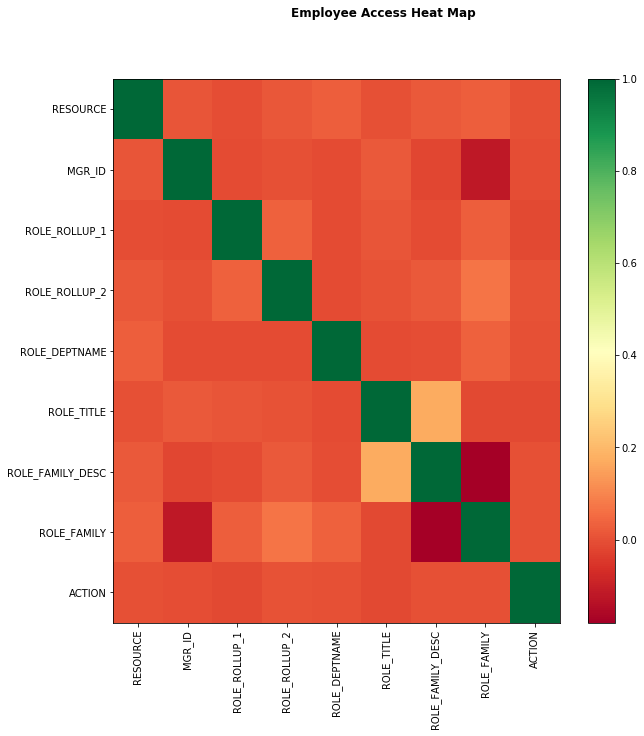

In [36]:
dataset = pd.concat([data, target], axis = 1)
corr = dataset.corr()
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Employee Access Heat Map', fontsize=12, fontweight='bold')
plt.show()

# 5.  Balancing the DataSet using SMOTE technique

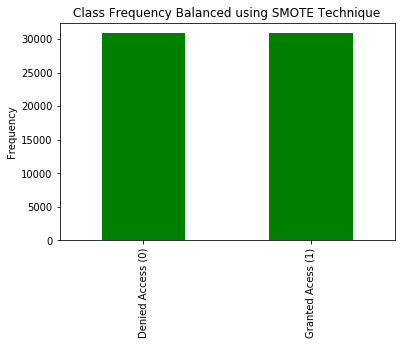

In [37]:
from imblearn.over_sampling import SMOTE

#smote technique
sm = SMOTE(random_state=42, kind='borderline1')
X_balanced, Y_balanced = sm.fit_sample(data, target.values.ravel())

#plot the balanced dataset
count_class = pd.value_counts(Y_balanced, sort= True).sort_index()
count_class.plot(kind = "bar", color = "green")
plt.ylabel("Frequency")
plt.xticks(np.arange(2), ('Denied Access (0)', 'Granted Acess (1)'))
plt.title("Class Frequency Balanced using SMOTE Technique")
plt.show()

In [38]:
X_balanced.shape

(61744, 8)

# 6. Feature Generation
#### One Hot encoding

In [39]:
#dataset is highly categorical so need to perform one-hot encoding
obj = preprocessing.OneHotEncoder()
obj.fit(X_balanced)
X_dummyEncode = obj.transform(X_balanced)
X_dummyEncode.shape

(61744, 72474)

Large number of sparse features so need to perform feature selection

# 7. Feature Selection

#### SelectKBest using chi2 score test

In [40]:
selectBest_attribute = SelectKBest(chi2, k= 550)
#fit and transforms the data
selectBest_attribute.fit(X_dummyEncode, Y_balanced)
modifiedData = selectBest_attribute.transform(X_dummyEncode)
modifiedData.shape

(61744, 550)

SelectKBest function reduced the features from 72474 to 550

#  8. Machine Learnig Models 

### 8.1 Naive Bayes

In [80]:
def Naive_Bayes(modifiedData, target):
    """
    This function implements Naive Bayes algorithm and plots the AUC graph
    :param modifiedData: the dataset
    :param target: the target class value
    :return: None
    """

    #BernoilliNB creates Niave Bayes object
    bernoilli_nb = BernoulliNB(alpha = 1)  # alpha = 1 performs laplace estimation, to handle zero frequency problem'

    #variable initialization
    random_seed = 31  #random seed value
    kFold = 10        #for 10 fold cross validation

    #stores fpr, tpr, auc for each fold
    mean_auc = 0
    fpr_score = []
    tpr_socre = []
    roc_auc_value = []
    fscre = 0

    #performs 10 fold cross validation
    for fold in range(kFold):

        #uses train test split of ratio 80:20 to perform 10 fold cross validation
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(modifiedData, target, test_size=.20,
                                                                        random_state= fold * random_seed)
        #fits and predicts the values
        bernoilli_nb.fit(X_train, np.ravel(Y_train,order='C'))
        prediction = bernoilli_nb.predict_proba(X_test)[:,1]
        tempPrediction = bernoilli_nb.predict(X_test)
        #calculates fpr and tpr, auc values
        fpr_score, tpr_score, roc_auc_value, mean_auc = roc_value(Y_test, prediction, fpr_score, tpr_socre, mean_auc, roc_auc_value)
        fscre  += f1Score(Y_test, tempPrediction)
    print("Mean AUC for Naive Bayes: %f" % (mean_auc / kFold))
    print("F1 - Score Naive Bayes: %f" % (fscre / kFold) )

    #plots AUC graph for Naive Bayes
    max_roc = roc_auc_value.index(max(roc_auc_value))
    plt.plot(fpr_score[max_roc], tpr_socre[max_roc], color = 'g', label = 'Naive Bayes')
    plt.legend(loc = 'lower right')

### 8.2 Logistic Regression

In [79]:
def Logistic_Regression(data, target):
    """
    This function implements Logistic Regression algorithm and plots the AUC graph
    :param modifiedData: the dataset
    :param target: the target class value
    :return: None
    """

    #creates object for logistic regression
    log_regrresion = linear_model.LogisticRegression(C=3)

    # variable initialization
    random_seed = 42   #random seed value
    kFold = 10         #for 10 fold cross validation

    #stores fpr, tpr, auc for each fold
    mean_auc = 0
    fpr_score = []
    tpr_socre = []
    roc_auc_value = []
    fscre = 0

    # performs 10 fold cross validation
    for fold in range(kFold):
        # uses train test split of ratio 80:20 to perform 10 fold cross validation
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data, target, test_size=.20, random_state= fold * random_seed)

        # fits and predicts the values
        log_regrresion.fit(X_train, np.ravel(Y_train,order='C'))
        prediction = log_regrresion.predict_proba(X_test)[:,1]
        tempPrediction = log_regrresion.predict(X_test)

        # calculates fpr and tpr, auc values
        fpr_score, tpr_score, roc_auc_value, mean_auc = roc_value(Y_test, prediction, fpr_score, tpr_socre, mean_auc, roc_auc_value)
        fscre  += f1Score(Y_test, tempPrediction)
    print("Mean AUC for Logistic Regression: %f" % (mean_auc / kFold))
    print("F1 - Score Logistic Regression: %f" % (fscre / kFold) )


    # plots AUC graph for Logistic Regression
    max_roc = roc_auc_value.index(max(roc_auc_value))
    plt.plot(fpr_score[max_roc], tpr_socre[max_roc], color = 'm', label = 'Logistic Regression')
    plt.legend(loc = 'lower right')

### 8.3 Random Forest

In [78]:
def Random_Forest(data, target):
    """
    This function implements Random Forest algorithm and plots the AUC graph
    :param modifiedData: the dataset
    :param target: the target class value
    :return: None
    """

    #creates object for random forest classifier
    random_forest = RandomForestClassifier(n_jobs= 10)

    # variable initialization
    random_seed = 31 #random seed value
    kFold = 10      #for 10 fold cross validation

    # stores fpr, tpr, auc for each fold
    mean_auc = 0
    fpr_score = []
    tpr_socre = []
    roc_auc_value = []
    fscre = 0

    # performs 10 fold cross validation
    for fold in range(kFold):
        # uses train test split of ratio 80:20 to perform 10 fold cross validation
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data, target, test_size=.20,random_state= fold * random_seed)

        # fits and predicts the values
        random_forest.fit(X_train, np.ravel(Y_train,order='C'))
        prediction = random_forest.predict_proba(X_test)[:, 1]
        tempPrediction = random_forest.predict(X_test)

        # calculates fpr and tpr, auc values
        fpr_score, tpr_score, roc_auc_value, mean_auc = roc_value(Y_test, prediction, fpr_score, tpr_socre, mean_auc,roc_auc_value)
        fscre  += f1Score(Y_test, tempPrediction)
        
    print("Mean AUC for Random Forest: %f" % (mean_auc / kFold))
    print("F1 - Score Random Forest: %f" % (fscre / kFold) )
    # plots AUC graph for Random Forest
    max_roc = roc_auc_value.index(max(roc_auc_value))
    plt.plot(fpr_score[max_roc], tpr_socre[max_roc], color='r', label='Random Forest')
    plt.legend(loc='lower right')

### 8.4 Support Vector Machines (SVM)

In [77]:
def SVM(data, target):
    """
    This function implements SVM algorithm and plots the AUC graph
    :param modifiedData: the dataset
    :param target: the target class value
    :return: None
    """

    #creates object for linear SVM
    linearSVM = LinearSVC(penalty = 'l1',  random_state= 37, max_iter=1000, dual=False, C=3)

    #initializing the variable
    random_seed = 42    #random seed value
    kFold = 10          #for 10 fold cross validation

    # stores fpr, tpr, auc for each fold
    mean_auc = 0
    fpr_score = []
    tpr_socre = []
    roc_auc_value = []
    fscre = 0

    # performs 10 fold cross validation
    for fold in range(kFold):
        # uses train test split of ratio 80:20 to perform 10 fold cross validation
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data, target, test_size=.20, random_state= fold * random_seed)

        # fits and predicts the values
        linearSVM.fit(X_train, np.ravel(Y_train,order='C'))
        prediction = linearSVM.predict(X_test)

        # calculates fpr and tpr, auc values
        fpr_score, tpr_score, roc_auc_value, mean_auc = roc_value(Y_test, prediction, fpr_score, tpr_socre, mean_auc, roc_auc_value)
        fscre  += f1Score(Y_test, prediction)
        
    print("Mean AUC for SVM: %f" % (mean_auc / kFold))
    print("F1 - Score SVM: %f" % (fscre / kFold) )

    # plots AUC graph for SVM
    max_roc = roc_auc_value.index("{0:.2f}".format(mean_auc / kFold))
    plt.plot(fpr_score[max_roc], tpr_socre[max_roc], color='y', label='SVM')
    plt.legend(loc='lower right')

### 8.5 K-Nearest Neighbors (KNN)

In [76]:
def KNN(data, target):
    """
    This function implements KNN algorithm and plots the AUC graph
    :param modifiedData: the dataset
    :param target: the target class value
    :return: None
    """

    #KNN object using 7 neighbors
    kneighbor = KNeighborsClassifier(n_neighbors=7)

    # variable initialization
    ramdom_seed = 42  #random seed value
    kFold = 10        #for 10 fold cross validation

    # stores fpr, tpr, auc for each fold
    mean_auc = 0
    fpr_score = []
    tpr_socre = []
    roc_auc_value = []
    fscre = 0
    # performs 10 fold cross validation
    for fold in range(kFold):
        # uses train test split of ratio 80:20 to perform 10 fold cross validation
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data, target, test_size=.20, random_state= fold * ramdom_seed)

        # fits and predicts the values
        kneighbor.fit(X_train, np.ravel(Y_train,order='C'))
        prediction = kneighbor.predict_proba(X_test)[:, 1]
        tempPrediction = kneighbor.predict(X_test)

        # calculates fpr and tpr, auc values
        fpr_score, tpr_score, roc_auc_value, mean_auc = roc_value(Y_test, prediction, fpr_score, tpr_socre, mean_auc,roc_auc_value)
        fscre  += f1Score(Y_test, tempPrediction)
        
    print("Mean AUC for KNN: %f" % (mean_auc / kFold))
    print("F1 - Score KNN: %f" % (fscre / kFold) )
    # plots AUC graph for KNN
    max_roc = roc_auc_value.index(max(roc_auc_value))
    plt.plot(fpr_score[max_roc], tpr_socre[max_roc], color='b', label='KNN')
    plt.legend(loc='lower right')

# 9. Evaluting the Models

### 9.1 AUC - ROC curves

In [46]:
def roc_value(Y_test, prediction, fpr_score, tpr_score, mean_auc, roc_auc_value):
    """
    This function calculates fpr, tpr and AUC curve value for any algorithm
    :param Y_test: the actual values of the target class
    :param prediction: the predicted values of the target class
    :param fpr_score: the false positve rate
    :param tpr_score: the true positive rate
    :param mean_auc: the mean value of AUC curve for 10 folds
    :param roc_auc_value: each auc curve value across 10 folds
    :return: roc_auc_value: each auc curve value across 10 folds
    """

    #calculates fpr and tpr values for each model
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, prediction)
    fpr_score.append(fpr)
    tpr_score.append(tpr)

    #calculates auc for each model
    roc_auc = metrics.auc(fpr, tpr)
    mean_auc = mean_auc + roc_auc
    roc_auc_value.append("{0:.2f}".format(roc_auc))

    return fpr_score, tpr_score, roc_auc_value, mean_auc

def plotGraph():
    """
    This function sets lables for X and Y axis
    :return: None
    """
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title("AUC comparison for all models.")
    plt.grid(True)
    plt.show()

### 9.2  f1-Score

In [49]:
def f1Score(Y_test, prediction):
    """
    This function calculates f1-score for any algorithm
    :param Y_test: the actual values of the target class
    :param prediction: the predicted values of the target class
    """
    score = f1_score(Y_test, prediction, average='binary')  
    return score 

# 10. Results - Raw Dataset

Mean AUC for Naive Bayes: 0.500284
F1 - Score Naive Bayes: 0.970168
Time Required for Naive Bayes in sec: 0.2097187042236328
------------------------------------------------------------------------------
Mean AUC for Logistic Regression: 0.506254
F1 - Score Logistic Regression: 0.970709
Time Required for Logistic regression in sec:  1.117307186126709
------------------------------------------------------------------------------
Mean AUC for Random Forest: 0.801557
F1 - Score Random Forest: 0.971252
Time Required for Random Forest in sec:  4.226995944976807
------------------------------------------------------------------------------
Mean AUC for KNN: 0.688220
F1 - Score KNN: 0.969470
Time Required for KNN in sec:  4.479097127914429
------------------------------------------------------------------------------
Mean AUC for SVM: 0.500000
F1 - Score SVM: 0.970709
Time Required for SVM in sec:  7.584714889526367
-----------------------------------------------------------------------------

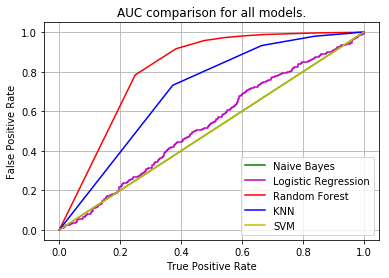

In [81]:
start_time = time.time()
Naive_Bayes(data, target)
print("Time Required for Naive Bayes in sec:",  (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
Logistic_Regression(data,target)
print("Time Required for Logistic regression in sec: ", (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
Random_Forest(data, target)
print("Time Required for Random Forest in sec: " ,  (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
KNN(data, target)
print("Time Required for KNN in sec: " , (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
SVM(data, target)
print("Time Required for SVM in sec: " ,(time.time() - start_time))
print("------------------------------------------------------------------------------")
plotGraph()

almost all the models performs worst (predicts outcome by chance) on the raw dataset
hence need to balance and extract features from the dataset 

# 11. Results - Balanced + OneHot + feature selection

Mean AUC for Naive Bayes: 0.917153
F1 - Score Naive Bayes: 0.855650
Time Required for Naive Bayes in sec: 0.33248376846313477
------------------------------------------------------------------------------
Mean AUC for Logistic Regression: 0.956718
F1 - Score Logistic Regression: 0.892818
Time Required for Logistic regression in sec:  2.9860918521881104
------------------------------------------------------------------------------
Mean AUC for Random Forest: 0.969870
F1 - Score Random Forest: 0.916322
Time Required for Random Forest in sec:  12.794313907623291
------------------------------------------------------------------------------
Mean AUC for SVM: 0.893701
F1 - Score SVM: 0.892678
Time Required for SVM in sec:  5.444817066192627
------------------------------------------------------------------------------


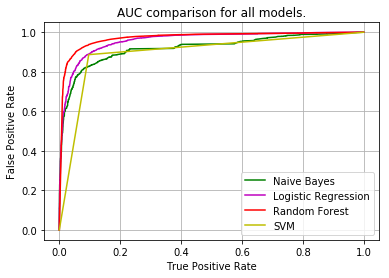

In [82]:
start_time = time.time()
Naive_Bayes(modifiedData, Y_balanced)
print("Time Required for Naive Bayes in sec:",  (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
Logistic_Regression(modifiedData,Y_balanced)
print("Time Required for Logistic regression in sec: ", (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
Random_Forest(modifiedData, Y_balanced)
print("Time Required for Random Forest in sec: " ,  (time.time() - start_time))
print("------------------------------------------------------------------------------")

start_time = time.time()
SVM(modifiedData, Y_balanced)
print("Time Required for SVM in sec: " ,(time.time() - start_time))
print("------------------------------------------------------------------------------")

plotGraph()

SMOTE + one-hot encoding + feature selection improved the performance of all the models

#### Random Forest performed best among all the classifiers with AUC = 0.969 and f1-Score of 0.91